---

# Yandex.Afisha Business Metrics Analysis

#### Objective: To help optimize marketing expenses for Yandex. Afisha

### Data Description

The visits table (server logs with data on website visits):

    Uid — user's unique identifier
    Device — user's device
    Start Ts — session start date and time
    End Ts — session end date and time
    Source Id — identifier of the ad source the user came from

The orders table (data on orders):

    Uid — unique identifier of the user making an order
    Buy Ts — order date and time
    Revenue — Yandex.Afisha's revenue from the order

The costs table (data on marketing expenses):

    source_id — ad source identifier
    dt — date
    costs — expenses on this ad source on this day

## Import data and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import scipy
from scipy import stats as st
import matplotlib.dates as md

In [2]:
visits = pd.read_csv('/datasets/visits_log_us.csv', dtype={'Device':'category'},parse_dates=['Start Ts','End Ts'])
orders = pd.read_csv('/datasets/orders_log_us.csv',parse_dates=['Buy Ts'])
costs = pd.read_csv('/datasets/costs_us.csv', parse_dates=['dt'])

In [3]:
display(visits.info())
display(visits.describe())
display(visits.sample())
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


None

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,Device,End Ts,Source Id,Start Ts,Uid
309512,desktop,2018-02-21 14:41:00,4,2018-02-21 14:37:00,11600786275014731898


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
display(orders.info())
display(orders.describe())
display(orders.sample())
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,Buy Ts,Revenue,Uid
19911,2017-11-25 02:59:00,1.53,8554616267537059038


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
display(costs.info())
display(costs.describe())
display(costs.sample())
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


None

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
2370,10,2017-12-09,20.9


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


> First look, we can see that there are columns that we need to change the data type, which we did when we load the data. It will help our data to be more readable and helps the data load faster. We also need to change the columns to lowercase and rename them

#### Visits

In [6]:
#Change column names to lower case
visits.columns = visits.columns.str.lower()

#Rename columns
visits = visits.rename(columns = {'end ts':'end_ts', 'start ts':'start_ts', 'source id':'source_id' })

#Check for duplicates
display(visits.duplicated().sum())

#Check for nulls
visits.isnull().sum()

0

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

#### Orders

In [7]:
#Change column names to lower case
orders.columns = orders.columns.str.lower()

#Rename columns
orders = orders.rename(columns = {'buy ts':'buy_ts'})

#Check for duplicates
display(orders.duplicated().sum())

#Check for nulls
orders.isnull().sum()



0

buy_ts     0
revenue    0
uid        0
dtype: int64

#### Costs

In [8]:
#Rename columns
costs = costs.rename(columns = {'dt':'ad_date', 'costs': 'ad_costs'})

#Check for duplicate
display(costs.duplicated().sum())

#Check for nulls
costs.isnull().sum()


0

source_id    0
ad_date      0
ad_costs     0
dtype: int64

#### Conclusion

> - We loaded the data with the right data types 
> - No duplicates and no nulls were found
> - We also changed the column names to lower case 
> - Renamed the columns to make it more understandable

## Calculate metrics and evaluate

### Product


#### How many people use it every day, week, and month?

In [9]:
#Create columns for day, week, month and year

visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].astype('datetime64[W]')
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['year'] = visits['start_ts'].astype('datetime64[Y]')

#Calculate daily active users
dau = visits.groupby('date').agg({'uid':'nunique'}).reset_index()
dau_total = dau.uid.mean()
wau = visits.groupby(['year','month','week']).agg({'uid':'nunique'}).reset_index()
wau_total = wau.uid.mean()
mau = visits.groupby(['year','month']).agg({'uid':'nunique'}).reset_index()
mau_total = mau.uid.mean()

print("Daily Usage: " + str(int(dau_total)) + " users")
print("Weekly Usage: " + str(int(wau_total)) + " users")
print("Monthly Usage: " + str(int(mau_total)) + " users")

Daily Usage: 907 users
Weekly Usage: 4912 users
Monthly Usage: 23228 users


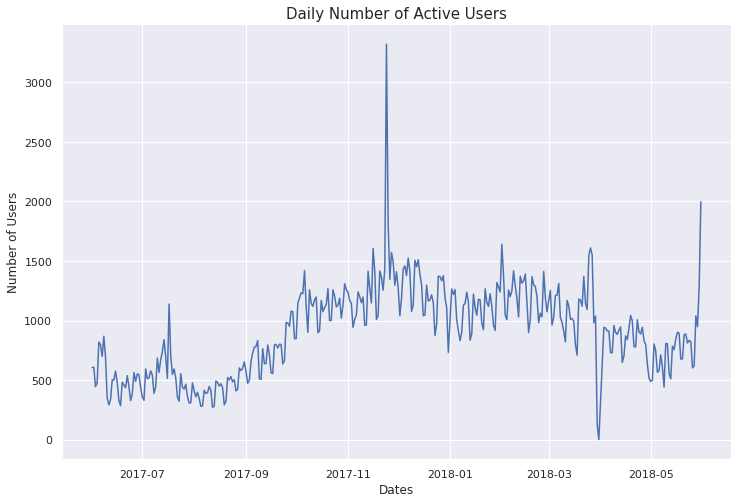

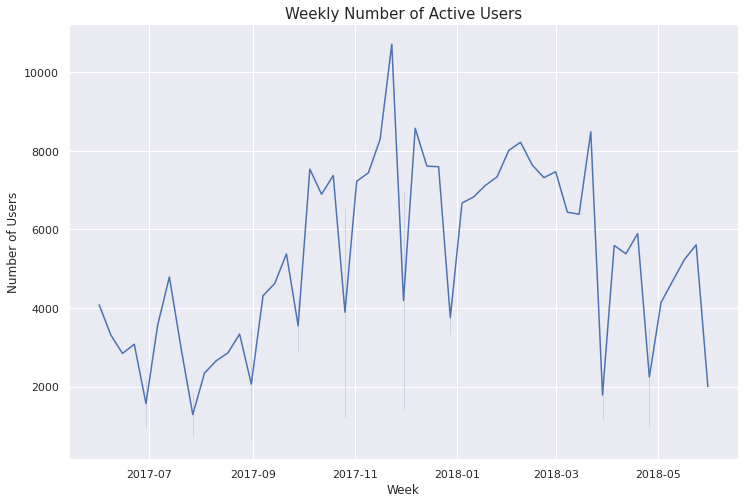

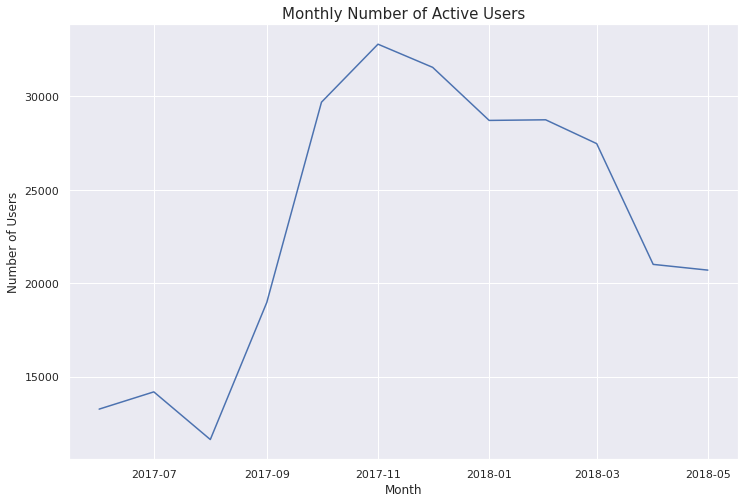

In [10]:
#Plot daily users
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='darkgrid')
sns.lineplot(data = dau, x='date',  y='uid')
plt.title("Daily Number of Active Users", fontsize =15)
plt.xlabel('Dates')
plt.xticks()
plt.ylabel('Number of Users')
plt.show()

#Plot weekly users
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='darkgrid')
sns.lineplot(data = wau, x='week',  y='uid')
plt.title("Weekly Number of Active Users", fontsize =15)
plt.xlabel('Week')
plt.ylabel('Number of Users')
plt.show()



#Plot monthly users
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='darkgrid')
sns.lineplot(data = mau, x='month',  y='uid')
plt.title("Monthly Number of Active Users", fontsize =15)
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.show()

> - Average daily users are ***907***, average weekly users are ***4912*** and average monthly users are ***23228***
> - Based on the graph above, the users fluctuates daily with the surge occuring between the end of November and December of 2017. It could be because there was a promotion going on or the company offered rewards to users. We can then see a sharp decline after that.
> - The graph shows that there are more users around winter time, with the least users in summer time specifically the month of August



#### How many sessions are there per day? (One user might have more than one session)

In [11]:
#Calculate session per day
sessions_per_day = visits.groupby('date').agg({'uid':['count', 'nunique']}).reset_index()
sessions_per_day.columns = ['session_date','n_sessions','n_users']

sessions_per_day_avg = sessions_per_day['n_sessions'].mean()
print('Sessions per day: ' + str(int(sessions_per_day_avg)) + " sessions")

Sessions per day: 987 sessions


In [12]:
#Calculate average sessions per user
avg_sessions_per_user = sessions_per_day_avg / dau_total
print('Average session per user daily: ' + str(avg_sessions_per_user.round(2)))

#calculate session per user
#sessions_per_user = visits.groupby('date').agg({'uid': ['count', 'nunique']}).reset_index()
#sessions_per_user.column = ['n_sessions', 'n_users']
#essions_per_day['sess_user'] = sessions_per_day['n_sessions'] / sessions_per_day['n_users']
#print(sessions_per_day['sess_user'].mean())

Average session per user daily: 1.09


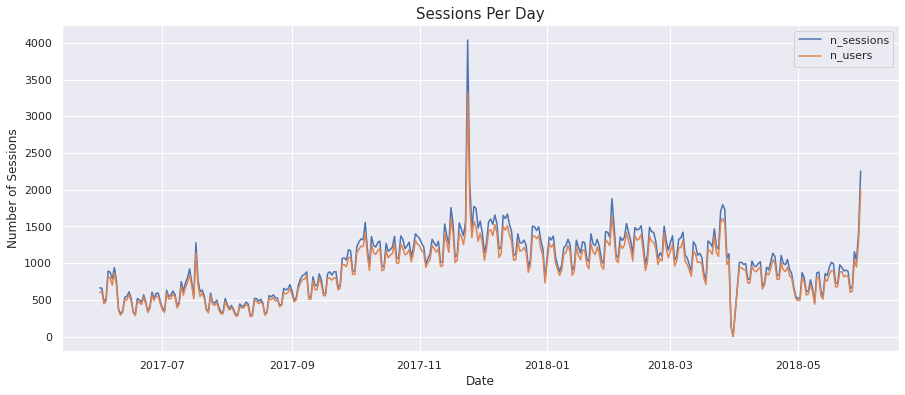

In [13]:
#Plot sessions per day and number of users
sns.set(rc={'figure.figsize':(15,6)})
sns.set(style='darkgrid')
sessions_per_day.plot(x='session_date',y=['n_sessions','n_users'])
plt.title('Sessions Per Day', fontsize =15)
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.show()




> There are ***987*** average sessions per day. Average session per user daily is at ***1.09***. Number of sessions are pretty much identical with the number of users. Each users spends at least one session per day 

In [14]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [15]:
#Calculate sessions per device type
sessions_touch = visits.query('device == "touch"').groupby('date').agg({'uid':'count'}).reset_index()
sessions_touch.columns = ['session_date','touch_sessions']
sessions_touch_avg = sessions_touch['touch_sessions'].mean()
print('Average number of session per user with touch: ' + str(sessions_touch_avg.round(2))+ " per day")

sessions_desktop = visits.query('device == "desktop"').groupby('date').agg({'uid':'count'}).reset_index()
sessions_desktop.columns = ['session_date', 'desktop_sessions']
sessions_desktop_avg = sessions_desktop['desktop_sessions'].mean()
print('Average number of session per user with desktop: ' + str(sessions_desktop_avg.round(2))+ " per day")

Average number of session per user with touch: 266.76 per day
Average number of session per user with desktop: 721.34 per day


In [16]:
#Merge touch and desktop sessions
sessions_desktop = sessions_desktop.merge(sessions_touch, on='session_date')


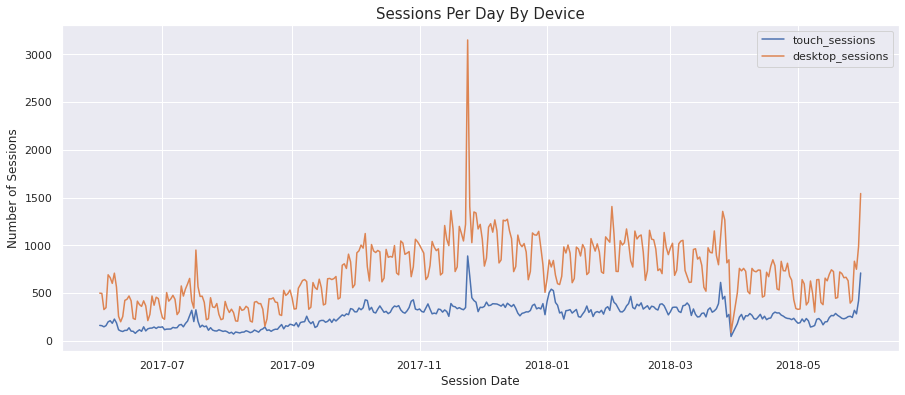

In [17]:
#Plot sessions per day by device
sns.set(rc={'figure.figsize':(15,6)})
sns.set(style='darkgrid')
sessions_desktop.plot(x='session_date', y=['touch_sessions', 'desktop_sessions'])
plt.title('Sessions Per Day By Device', fontsize =15)
plt.xlabel('Session Date')
plt.ylabel('Number of Sessions')
plt.show()

> As we can see, more users use desktop than mobile to access the site. It could be compatibility issues or the website layout on desktop is more readble than the mobile version.

#### What is the length of each session?

In [18]:
#calculate the duration in seconds
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
asl = visits['session_duration_sec'].mode()
print('Average session length : {} seconds'.format(int(asl)))
asl_avg = visits['session_duration_sec'].mean()/60
print('Average duration in minutes: {} minutes'.format(int(asl_avg)))


Average session length : 60 seconds
Average duration in minutes: 10 minutes


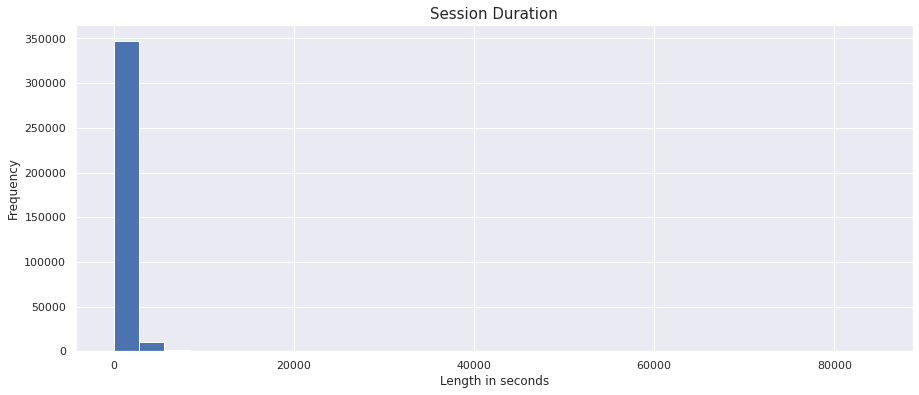

In [19]:
#Plot the session length in seconds
plt.figsize=(10,5)
visits['session_duration_sec'].plot.hist(bins=30)
plt.title('Session Duration', fontsize = 15)
plt.xlabel('Length in seconds')
plt.show()



In [20]:
#Look at the session duration closely
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [21]:
#Find how many sessions are equal to 0
visits[visits['session_duration_sec'] ==0].head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration_sec
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0
28,desktop,2017-11-09 15:53:00,4,2017-11-09 15:53:00,17892541477379911957,2017-11-09,2017-11-09,2017-11-01,2017-01-01,0
32,desktop,2017-11-30 12:29:00,4,2017-11-30 12:29:00,13410401624913285510,2017-11-30,2017-11-30,2017-11-01,2017-01-01,0
54,desktop,2018-02-23 16:52:00,10,2018-02-23 16:52:00,13423278602430425332,2018-02-23,2018-02-22,2018-02-01,2018-01-01,0


In [22]:
#Find out how long the sessions per device
duration_per_device = visits.groupby('device').session_duration_sec.mean().round(2).reset_index()
duration_per_device

,device,session_duration_sec
0,desktop,703.95
1,touch,479.62


>  The average length users spent on the website is 10 minutes but this is biased due to very long sessions with the max lasting almost a day. The distribution is far from normal so we had to use the mode. We got 60 seconds as the average session length. 25% of users spent a minute or less on the site. It could be connection issues or the user losing interest.
> Desktop users tend to spend more on the site than touch users with 703 seconds or 11 minutes compare to touch users with 8 minutes.



#### How often do users come back?

In [23]:
#Calculate the first time user visited the site
first_session_datetime = visits.groupby('uid').start_ts.min()
first_session_datetime.name = 'first_session_datetime'
user_retention = visits.join(first_session_datetime, on='uid')

user_retention['first_session_month'] = user_retention['first_session_datetime'].astype('datetime64[M]')
user_retention['session_month'] = user_retention['start_ts'].astype('datetime64[M]')


In [24]:
#Calculate cohort lifetime
user_retention['lifetime'] = user_retention['session_month'] - user_retention['first_session_month']
user_retention['lifetime'] = user_retention['lifetime'] / np.timedelta64(1,'M')
user_retention['lifetime'] = user_retention['lifetime'].round().astype('int')
user_retention['first_session_month'] = user_retention['first_session_month'].dt.strftime('%Y-%m')
cohorts = user_retention.groupby(['first_session_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()

In [25]:
#Calculate first month users
first_month_users = cohorts.query('lifetime == 0')[['first_session_month', 'uid']]
first_month_users = first_month_users.rename(columns={'uid' :'cohort_users'})

cohorts = cohorts.merge(first_month_users, on='first_session_month')
cohorts['retention_rate'] = cohorts['uid'] / cohorts['cohort_users']

In [26]:
#Group the data
cohorts_pivot = cohorts.pivot_table(index ='first_session_month', columns='lifetime',\
                                    values='retention_rate', aggfunc='sum')

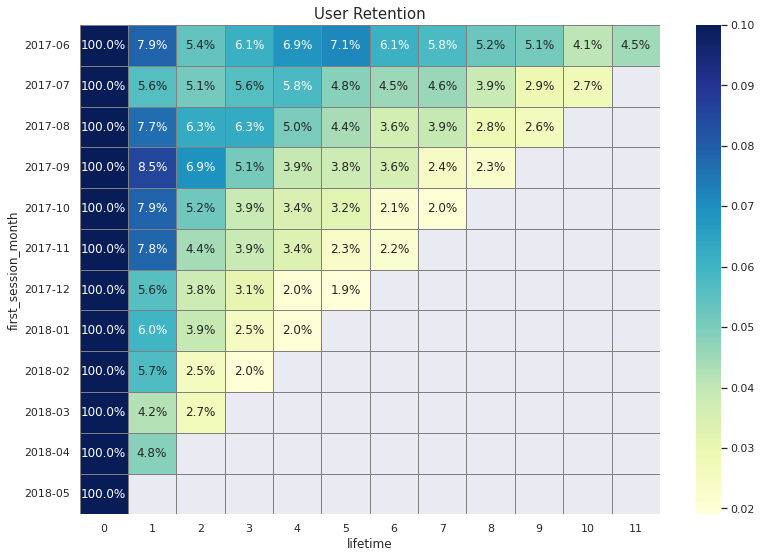

In [27]:
#Build a heatmap
plt.figure(figsize=(13, 9))
plt.title('User Retention', fontsize=15)
sns.heatmap(cohorts_pivot,annot=True,fmt='.1%',linewidths=1,vmax= .1,linecolor='gray',cmap ='YlGnBu')
plt.show()

> The graph shows that there are not a lot of users that return monthly and as the months progressed, the number of users decreased. Less than 9 percent of users come back after their initial interaction with the site. We need to figure out reasons why users are leaving and develop a plan for user retention. It is more cost effective to market to current users rather than to try to bring in new users.


#### Product Conclusion

> -  Average daily users are ***907***, average weekly users are ***4912*** and average monthly users are ***23228***
> -  there are more users around winter time, with the least users in summer time specifically the month of August
> - There are ***987*** sessions per day. Average session per user daily is at ***1.09***
> - Each users spends at least one session per day 
> - There are significantly higher desktop users than touch users. It could be because of compatibility issues or the site is more user friendly on the desktop.
> - Users are more likely to visit the site using a desktop than a touch device which is a bit surprising since people are on their phones a lot.
> - The average length users spent on the website is ***10 minutes*** but this is biased due to very long sessions with the max lasting almost a day. 
> - The distribution is far from normal so we had to use the mode 
> - Average session length is ***60 seconds***. ***25%*** of users spent a minute or less on the site. It could be connection issues or the user losing interest
> Desktop users tend to spend more on the site than touch users with ***703 seconds*** or ***11 minutes*** compare to touch users with 8 minutes
> - User retention rate is very low and never exceeds ***9%***

### Sales

#### When do people start buying?

In [28]:
#Find the initial purchase of customers
first_order_date = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_order_date.name = 'first_order_date'
first_order_date.columns = ['uid', 'first_order_date']
first_visit = visits.groupby('uid').agg({'start_ts':'min','device':'first','source_id':'first'}).reset_index()
first_visit.columns = ['uid', 'first_visit_date','device', 'source_id']

#Merge with visits
sale_conversion = first_order_date.merge(first_visit, on='uid')
sale_conversion['conv_day'] = sale_conversion['first_order_date'] - sale_conversion['first_visit_date'] 
sale_conversion['conv_day'] = sale_conversion['conv_day'].dt.days.astype('int')




In [29]:
#Merge the visits and orders datasets
vis_order = orders.merge(first_visit, on='uid',how='left')
vis_order['first_visit_month'] = vis_order['first_visit_date'].astype('datetime64[M]')


In [30]:
#Calculate average conversion
sale_conversion_avg = sale_conversion['conv_day'].mode()
print('Average sale conversion: {} days'.format(int(sale_conversion_avg)))


Average sale conversion: 0 days


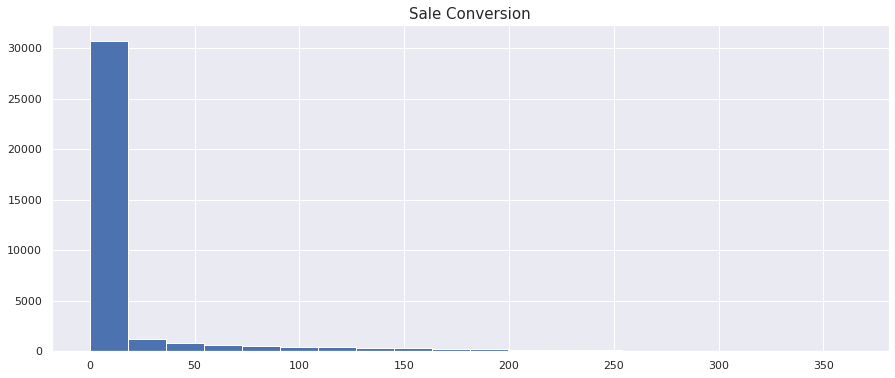

In [31]:
#Plot sale conversion
plt.hist(sale_conversion['conv_day'], bins = 20)
plt.title("Sale Conversion", fontsize = 15)
plt.show()

In [32]:
sale_conversion['conv_day'].describe().round(2)

count    36523.00
mean        16.73
std         46.96
min          0.00
25%          0.00
50%          0.00
75%          2.00
max        363.00
Name: conv_day, dtype: float64

In [33]:
#Sort how long users become a customer
def conversion_length(x):
    if x == 0:
        return 'Conversion in 0 day'
    if x <= 5:
        return 'Conversion in 5 days'
    if x <= 10:
        return 'Conversion in 10 days'
    if x <= 20:
        return 'Conversion in 20 days'
    if x <=30:
        return 'Conversion in 30 days'
    if x <= 60:
        return 'Conversion in 60 days'
    if x > 60:
        return 'Conversion in more than 60 days'

In [34]:
#Calculate conversion
sale_conversion['conv_length'] = sale_conversion['conv_day'].apply(conversion_length)
cust_conversion = sale_conversion.groupby('conv_length').agg({'conv_length' :'count'})
cust_conversion = cust_conversion.rename(columns = {'conv_length':'conv_count'})
cust_conversion = cust_conversion.reset_index()
cust_conversion['cust_ratio'] = cust_conversion['conv_count'] / cust_conversion['conv_count'].sum()*100


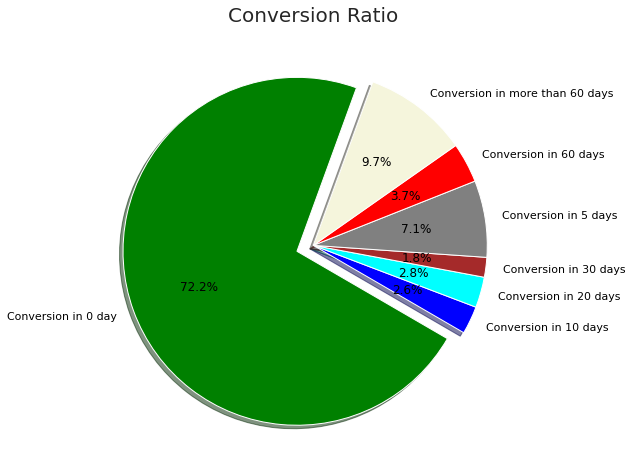

In [35]:
#Plot a pie graph to visualize distribution
fig, ax = plt.subplots(figsize =(20,8))
explode = (0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
colors = ( "green","blue","cyan", "brown",
          "grey", "red", "beige")
ax.pie(cust_conversion['cust_ratio'],
       autopct = "%.1f%%", 
       labels = cust_conversion['conv_length'],
       explode=explode,
       shadow = True,
       colors = colors,
       startangle = 70,
       textprops = dict(color ="black"))
ax.set_title("Conversion Ratio",fontsize=20)
plt.show()

> Based on the graph above, majority of visitors, about ***72%*** ordered on their first visit and about ***10%*** ordered after 2 months of using the site. 

In [36]:
#Calculate the conversion by source
conv_by_source = sale_conversion.groupby('source_id').agg({'conv_day':['mean','count']}).reset_index()
conv_by_source.columns = ['source_id','mean','source_count']
conv_by_source['source_ratio'] = conv_by_source['source_count'] / conv_by_source['source_count'].sum() * 100

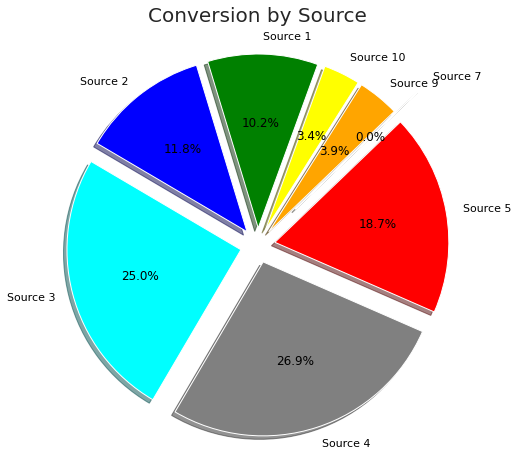

In [37]:
#Create label for source_id
def label(x):
    graph_label = 'Source ' + str(int(x['source_id']))
    return graph_label
conv_by_source['label'] = conv_by_source.apply(label, axis =1)
    
fig, ax = plt.subplots(figsize =(20,8))
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.3, 0.1, 0.1)
colors = ( "green","blue","cyan","grey", "red", "beige","orange", "yellow")
ax.pie(conv_by_source['source_ratio'],
       autopct = "%.1f%%", 
       labels = conv_by_source['label'],
       explode=explode,
       shadow = True,
       colors = colors,
       startangle = 70,
       textprops = dict(color ="black"))
ax.set_title("Conversion by Source",fontsize=20)
plt.show()

> The most popular sources are ***source 3*** and ***source 4*** and the least popular is ***source 7***.

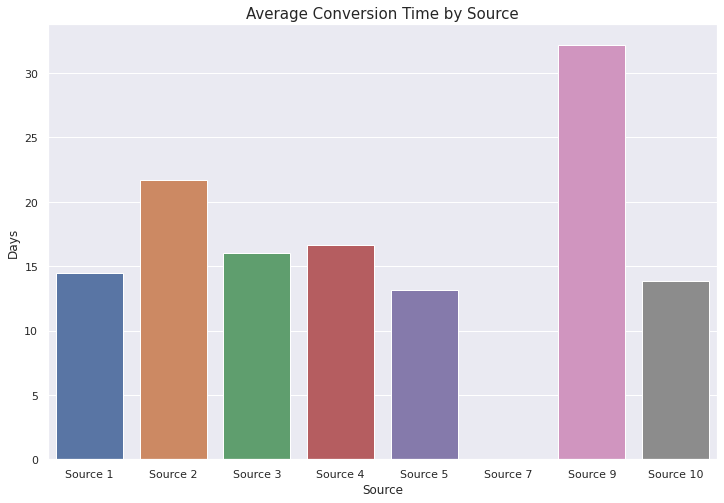

In [38]:
#Plot average conversion time by source
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='darkgrid')
sns.barplot(data = conv_by_source, x='label',  y='mean')
plt.title("Average Conversion Time by Source", fontsize =15)
plt.xlabel('Source')
plt.ylabel('Days')
plt.show()



> ***Source 9*** has the longest conversion period while ***sources 1 and 10*** has the best converson time with 14 and 13 days.

In [39]:
#Calculate conversion by device
conv_by_device = sale_conversion.groupby('device').agg({'conv_day':'count'}).reset_index()
conv_by_device.columns = ['device','device_count']
conv_by_device['device_ratio'] = conv_by_device['device_count'] / conv_by_device['device_count'].sum() * 100

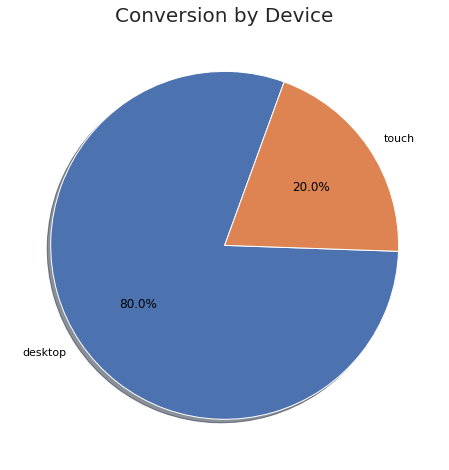

In [40]:
#Plot graph to visualize
fig, ax = plt.subplots(figsize =(20,8))
ax.pie(conv_by_device['device_ratio'],autopct = "%.1f%%", labels = conv_by_device['device'],\
       shadow = True,startangle = 70,
       textprops = dict(color ="black"))
ax.set_title("Conversion by Device",fontsize=20)
plt.show()

> About of ***80%*** of customers use desktop and only ***20%*** use their mobile when making a purchase

#### How many orders do they make during a given period of time?

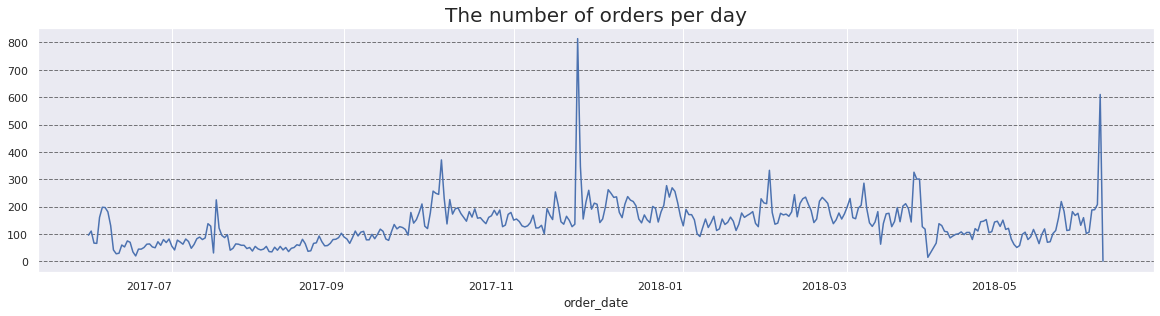

In [41]:
#Sort the dates out
orders['order_date'] = orders['buy_ts'].dt.date
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

#Number of orders by day
ax = orders.groupby('order_date').uid.count().plot(figsize=(20,5));
ax.set_title('The number of orders per day', fontsize=20);
ax.grid(axis='y', linestyle='--', color='black', alpha=0.5)
plt.show()

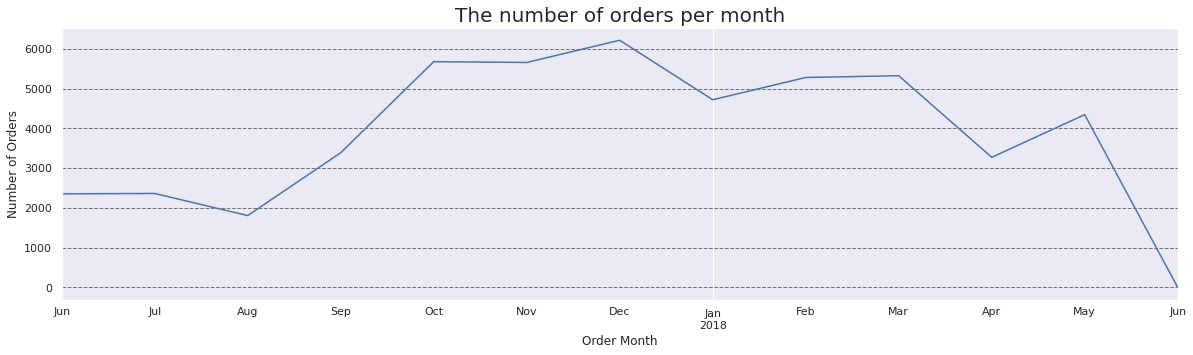

In [42]:
ax = orders.groupby('order_month').uid.count().plot(figsize=(20, 5));
ax.set_title('The number of orders per month', fontsize=20);
ax.grid(axis='y', linestyle='--', color='black',alpha=0.5)
plt.ylabel('Number of Orders')
plt.xlabel('Order Month')
plt.show()


> As we can see from the graph above, the highest number of orders were made on December 2017. This makes sense as people tend to buy more around the holiday season. This also confirms the increase in user sessions around this time as per our previous findings.

In [43]:
#Merge order and visits
orders_ = orders.merge(first_visit, on='uid').reset_index()

In [44]:
#Extract lifetime months
orders_['lifetime_months'] = (orders_.order_date - orders_.first_visit_date)/np.timedelta64(1,'M')
orders_['lifetime_months'] = orders_.lifetime_months.astype(int).round().astype(int)

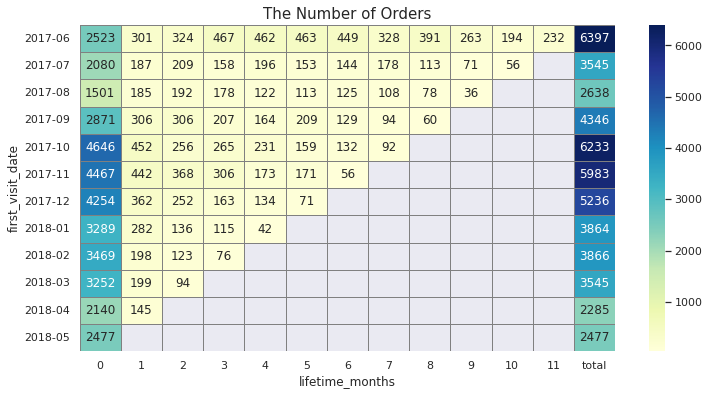

In [45]:
#Get the order count
order_counts = orders_.pivot_table(index=orders_.first_visit_date.astype('datetime64[M]'),columns='lifetime_months',
values='uid', aggfunc='count')
order_counts['total'] = order_counts.sum(axis=1)

#Build a heatmap
plt.figure(figsize=(12, 6)) 
plt.title('The Number of Orders', fontsize = 15) 
ax = sns.heatmap(order_counts, annot=True, fmt='g', linewidths=1, linecolor='gray', cmap ='YlGnBu'); 
dates = order_counts.reset_index()['first_visit_date'].sort_values().dt.strftime('%Y-%m').unique()
ax.set_yticklabels(labels=dates);


> As we can see from the graph above, the highest number of orders were made on December 2017. This makes sense as people tend to buy more around holiday season. 

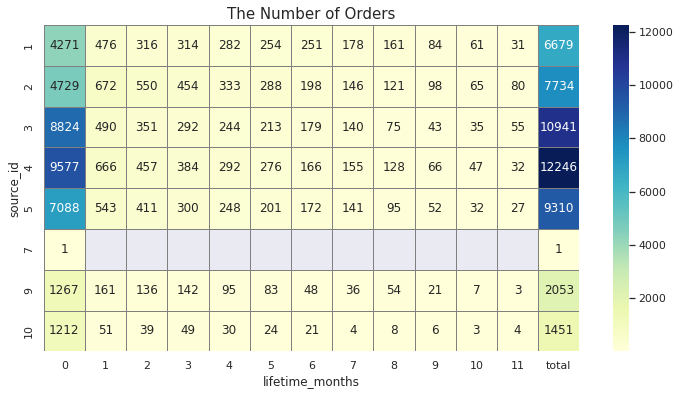

In [46]:
#Order by sources pivot table
order_by_sources = orders_.pivot_table(index='source_id',columns='lifetime_months',
values='uid', aggfunc='count')
order_by_sources['total'] = order_by_sources.sum(axis=1)

plt.figure(figsize=(12, 6)) 
plt.title('The Number of Orders', fontsize = 15) 
ax = sns.heatmap(order_by_sources, annot=True, fmt='g', linewidths=1, linecolor='gray', cmap ='YlGnBu'); 
sources = order_by_sources.reset_index()['source_id'].sort_values().unique()
ax.set_yticklabels(labels=sources);


> ***Source 4*** and ***source 3*** have the most number of orders

#### What is the average purchase size?

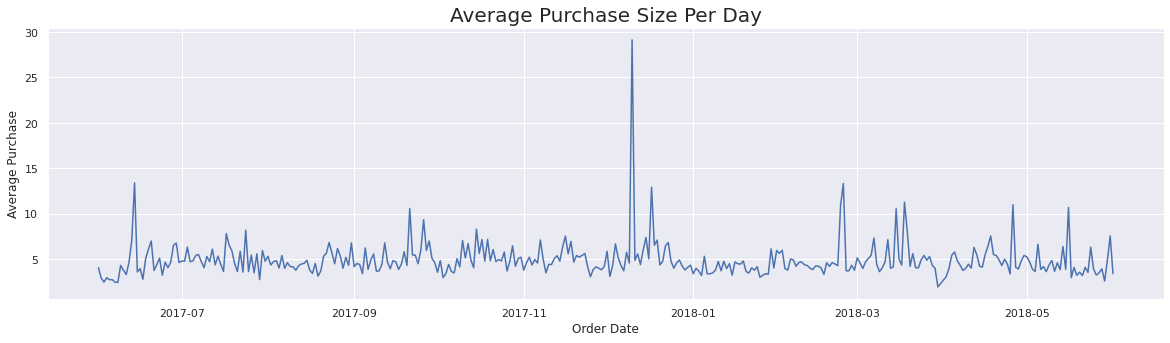

In [47]:
#Calculate average purchase size
avg_purchase = orders.groupby('order_date').revenue.mean().reset_index()


#Plot graph of average purchase
sns.set(rc={'figure.figsize':(20,5)})
sns.set(style='darkgrid')
sns.lineplot(data = avg_purchase,x='order_date',y='revenue',estimator='mean')
plt.title('Average Purchase Size Per Day', fontsize =20)
plt.ylabel('Average Purchase')
plt.xlabel('Order Date')
plt.show()

In [48]:
display(round(pd.DataFrame(orders.groupby('order_date').revenue.mean().describe()).T,2))

,count,mean,std,min,25%,50%,75%,max
revenue,364.0,4.94,2.02,1.95,3.96,4.56,5.41,29.13


> Average purchase per day is about $5 with the highest purchase made in December 2017

#### How much money do they bring? (LTV)

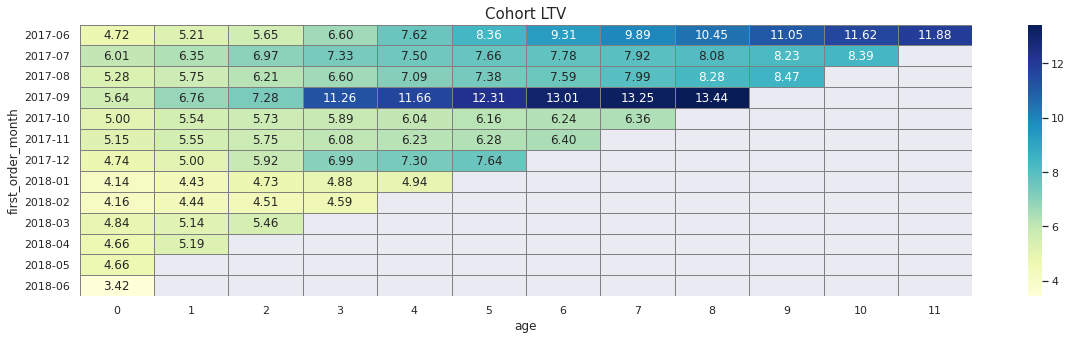

In [49]:
#Find the date of the customer's first purchase
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders


#Create cohorts size based on first purchase
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

#Merge the orders table to build cohorts
orders_calc = pd.merge(orders,first_orders, on='uid')


#Group the table by first purchase month and order month
cohorts = orders_calc.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

#Merge cohort table
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

#Calculate cohort's maturity
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
#report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m')

#Calculate LTV
report['ltv'] = report['revenue'] / report['n_buyers']


#Create pivot table and buikd a heatmap to visualize
ltv_pivot = report.pivot_table(
    index = 'first_order_month',
    columns = 'age',
    values = 'ltv',
    aggfunc = 'mean').cumsum(axis=1)


ax = sns.heatmap(ltv_pivot, annot= True,fmt='.2f',linewidths=1,linecolor='gray',cmap = 'YlGnBu' )
labels = ltv_pivot.reset_index()['first_order_month'].sort_values().dt.strftime('%Y-%m').unique()
ax.set_yticklabels(labels=labels);
plt.title('Cohort LTV', fontsize=15)
plt.show()

> As we can see first cohort and fourth cohort brought in the most profit. Each users from first cohort brought ***11.88*** in profit and fourth cohort brought in ***13.44*** in profit

#### Conclusion

> - On average, people started buying within ***0*** days
> - The most popular sources are ***source 3*** and ***source 4*** and the least popular is ***source 7***
> - Most customers use their desktop, about **80%*** compare to ***20%*** mobile when making a purchase.
> - The numbers of orders are at the highest on December which confirms the increase in user activity around this time
> - ***Source 9*** has the longest conversion period while ***sources 1 and 10*** has the best converson time with 14 and 13 days
> - ***Source 4*** and ***source 3*** have the most number of orders
> - Average purchase per day is about $5 with the highest purchase made in December 2017
> - First cohort and fourth cohort brought in the most profit. Each users from first cohort brought ***11.88*** in profit and fourth cohort brought in ***13.44*** in profit

### Marketing

#### How much money was spent? Overall/per source/over time

Daily Costs


,count,mean,std,min,25%,50%,75%,max
ad_costs,364.0,904.21,396.96,0.7,595.68,873.66,1155.6,3458.86


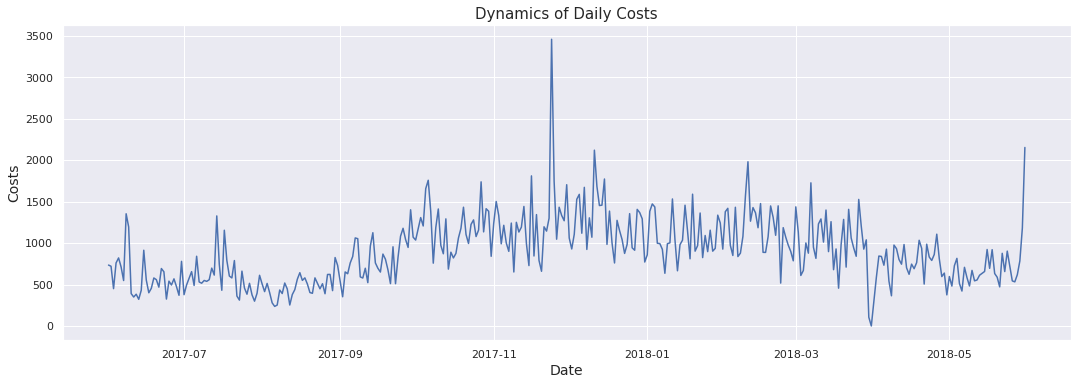

Monthly Costs


,count,mean,std,min,25%,50%,75%,max
ad_costs,12.0,27427.64,8405.07,14790.54,21228.35,27392.09,34219.61,38315.35


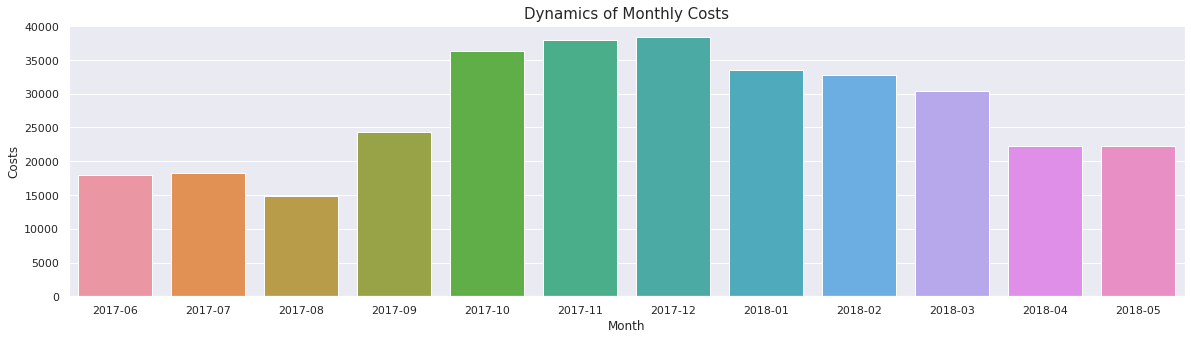

In [50]:
#Find the day and month when the money was spent
costs['ad_day'] = costs['ad_date'].dt.date
costs['ad_month'] = costs['ad_date'].astype('datetime64[M]').dt.to_period('M')

daily_costs = costs.groupby('ad_day').agg({'ad_costs':'sum'})
monthly_costs = costs.groupby('ad_month').agg({'ad_costs':'sum'}).reset_index()



print('Daily Costs')
display(round(pd.DataFrame(daily_costs.describe()).T,2))

fig, ax = plt.subplots(figsize=(20, 6))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.plot(daily_costs,)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Costs', fontsize=14)
ax.set_title('Dynamics of Daily Costs', fontsize=15)
plt.show()


print('Monthly Costs')
display(round(pd.DataFrame(monthly_costs.describe()).T,2))

sns.barplot(data=monthly_costs, x='ad_month',  y='ad_costs')#estimator=sum)
plt.title("Dynamics of Monthly Costs", fontsize =15)
plt.xlabel('Month')
plt.ylabel('Costs')
plt.show()

#display(round(pd.DataFrame(daily_costs.describe()).T,2))
#display(round(pd.DataFrame(monthly_costs.describe()).T,2))



> Monthly costs for marketing is at the highest in November and December. This makes sense since it's around holiday season and companies heavily advertise around this time to try to lure in customers. On average marketing costs \\$904 per day and \\$27428 per month

In [51]:
#Find costs by source
source_costs = costs.groupby('source_id').agg({'ad_costs':'sum'}).reset_index()
source_costs
source_costs['label'] = source_costs.apply(label,axis=1)

In [52]:
#source_costs
costs.groupby('source_id').agg({'ad_costs':'sum'})

,ad_costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


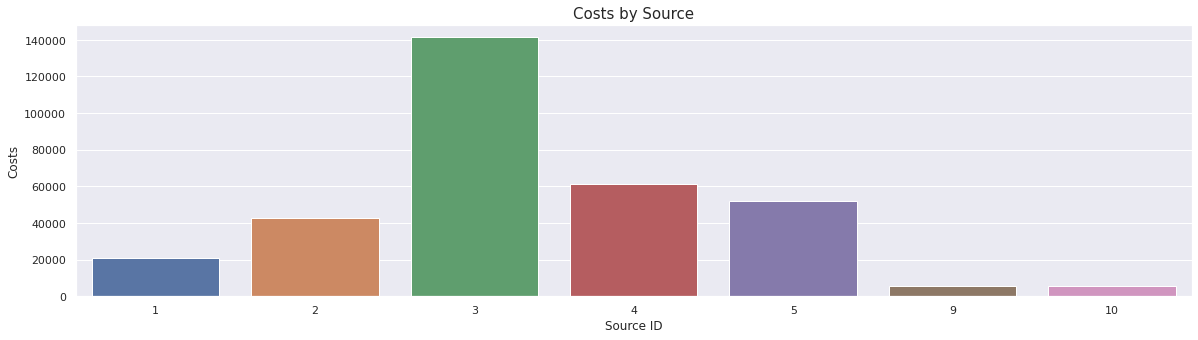

In [53]:
#Plot cost by source
sns.barplot(data=source_costs, x='source_id',  y='ad_costs')
plt.title("Costs by Source", fontsize =15)
plt.xlabel('Source ID')
plt.ylabel('Costs')
plt.show()

>  The highest marketing costs comes from ***source 3*** and the lowest is ***source 10***. As our previous findings, ***source 4*** and ***source 3*** had about the same conversion rate but source 3 cost at least 3 times more than source 4. We might want to focus more on other sources rather than spending it on source 3

#### How much did customer acquisition from each of the sources cost?

In [54]:
#Convert first order month
report['first_order_month']= report['first_order_month'].astype('datetime64[M]').dt.to_period('M')


In [55]:
#Add cac to report
def add_cac(report):
    monthly_costs = costs.groupby('ad_month').ad_costs.sum().astype('int').reset_index()
    report = report.merge(monthly_costs, left_on='first_order_month',right_on='ad_month').reset_index()
    report['cac'] = report['ad_costs'] /report['n_buyers']  
    return report

#adding CAC to the report
report = add_cac(report)


In [56]:
report
round(report.groupby(['first_order_month', 'ad_costs', 'n_buyers', 'cac'])\
      .agg({'ltv':['sum', 'mean', 'count']}).reset_index(),2)

first_order_month ad_costs n_buyers    cac    ltv            
                                                 sum  mean count
0            2017-06    18015     2023   8.91  11.88  0.99    12
1            2017-07    18240     1923   9.49   8.39  0.76    11
2            2017-08    14790     1370  10.80   8.47  0.85    10
3            2017-09    24368     2581   9.44  13.44  1.49     9
4            2017-10    36322     4340   8.37   6.36  0.80     8
5            2017-11    37907     4081   9.29   6.40  0.91     7
6            2017-12    38315     4383   8.74   7.64  1.27     6
7            2018-01    33518     3373   9.94   4.94  0.99     5
8            2018-02    32723     3651   8.96   4.59  1.15     4
9            2018-03    30415     3533   8.61   5.46  1.82     3
10           2018-04    22289     2276   9.79   5.19  2.59     2
11           2018-05    22224     2988   7.44   4.66  4.66     1

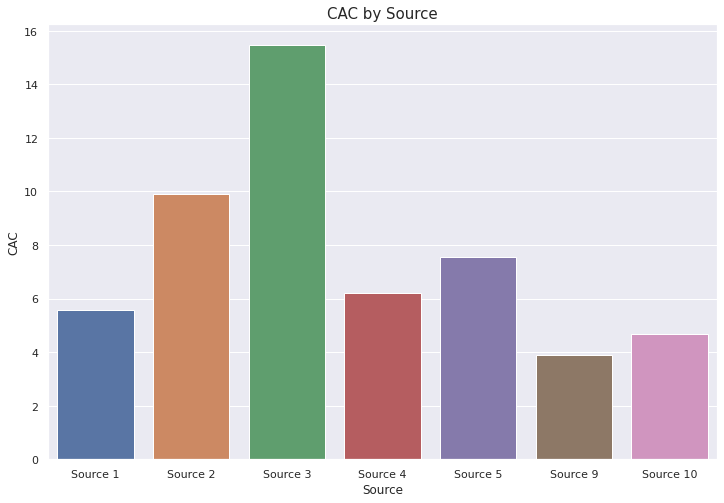

In [57]:
#Calculate the number of customers per sources
total_source_cust = vis_order.groupby('source_id', as_index=False).agg({'uid':'nunique'})
source_costs = source_costs.merge(total_source_cust, on='source_id')
source_costs = source_costs.rename(columns = {'uid':'n_buyers'})

#Calculate cac by source
source_costs['cac'] = source_costs['ad_costs'] / source_costs['n_buyers']

#Plot cac by source
sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='darkgrid')
sns.barplot(data = source_costs, x='label',  y='cac')
plt.title("CAC by Source", fontsize =15)
plt.xlabel('Source')
plt.ylabel('CAC')
plt.show()


> Source 3 has the highest customer acquisition costs with source 2 coming in at second. Source 9 have the lowest customer acquisition cost

#### ROI

In [58]:
#Calculate ROI
report_final = report.copy()
report_final

report_final['romi'] = report_final['ltv'] / report_final['cac']


,first_visit_month,revenue
0,2017-06-01,40026.05
1,2017-07-01,17812.11
2,2017-08-01,13461.87
3,2017-09-01,33682.56
4,2017-10-01,27857.69
5,2017-11-01,24426.72
6,2017-12-01,31157.85
7,2018-01-01,14546.82
8,2018-02-01,15061.29
9,2018-03-01,13770.16


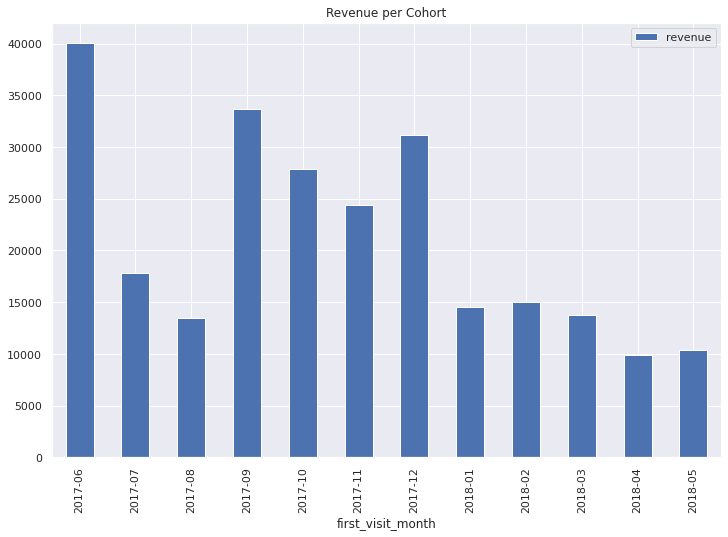

In [59]:
#Calculate revenue per cohort
cohorts_rev = ( 
    vis_order.
    groupby('first_visit_month', as_index = False).
    agg({'revenue':'sum'})
)
display(cohorts_rev)


#Plot revenue per cohort
ax = cohorts_rev.plot(kind='bar', x= 'first_visit_month', y='revenue')
labels = cohorts_rev['first_visit_month'].dt.strftime('%Y-%m').unique()
ax.set_xticklabels(labels=labels);
plt.title('Revenue per Cohort')
plt.show()



> Revenue is at the highest on first cohort, followed by September cohort and April cohort having the lowest revenue

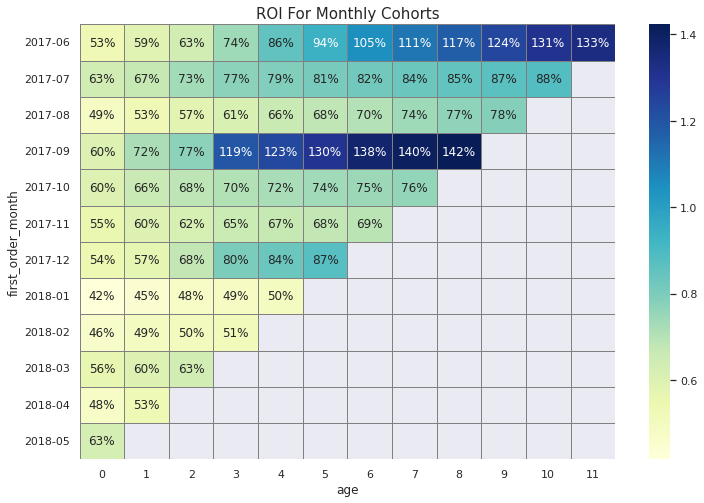

In [60]:
# Build a heatmap for monthly cohortsfig, ax = plt.subplots(figsize=(15, 6))
romi_pivot = report_final.pivot_table(
    index = 'first_order_month',
    columns = 'age',
    values = 'romi',
    aggfunc = 'sum').cumsum(axis=1)

sns.heatmap(romi_pivot, annot= True,fmt='.0%',linewidths=1,linecolor='gray',cmap = 'YlGnBu' )
plt.title('ROI For Monthly Cohorts', fontsize = 15)
plt.show()


> As we can see June and September cohort were the only cohort that was profitable and the rest were not. Our company will keep losing money and definitely not going to last if we continue to market the way we do now. The increase in marketing expense during holidays did nothing on our profits.

In [61]:
#Select columns needed to calculate romi 
orders_['first_visit_month'] = orders_['first_visit_date'].astype('datetime64[M]')
report_romi = orders_.filter(['revenue', 'first_visit_month', 'order_month','order_date','source_id'], axis=1)


#Calculate lifetime
report_romi['lifetime'] = (report_romi['order_month'] - report_romi['first_visit_month'] )/ np.timedelta64(1,'M')
report_romi['lifetime'] = report_romi['lifetime'].astype(int)

In [62]:
# Group romi by source_id and lifetime
lifetime_source = (report_romi.groupby(['source_id','lifetime'],as_index = False)
                   .agg({'revenue':'sum'}).reset_index()
)

#Calculate revenue's cumulative sum
rev_cumsum = ( 
    lifetime_source.
    groupby('source_id').
    agg({'revenue':'cumsum'}).reset_index()
)
rev_cumsum = rev_cumsum.rename(columns = {'revenue':'revenue_from_source'})

In [63]:
#Merge lifetime with revenue's cumsum
lifetime_source = lifetime_source.merge(rev_cumsum, on='index')


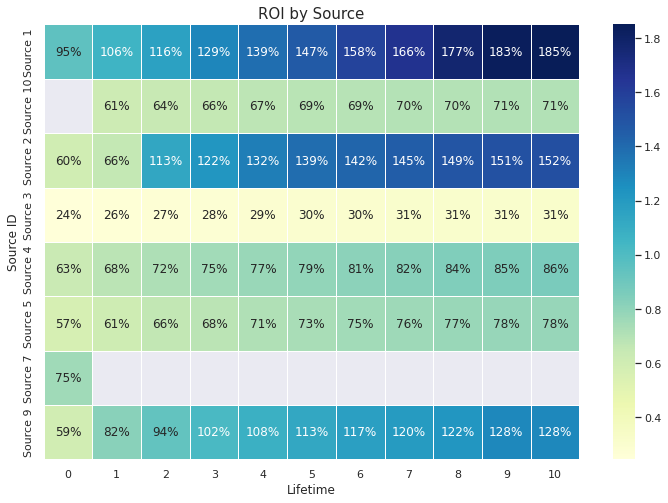

In [64]:
#Group costs by source
costs_source = costs.groupby('source_id',as_index = False).agg({'ad_costs':'sum'})

#Merge lifetime with costs by source
total_source = lifetime_source.merge(costs_source, on = 'source_id')

#Calculate romi
total_source['label'] = lifetime_source.apply(label, axis=1)
total_source['romi'] = total_source['revenue_from_source'] / total_source['ad_costs']

#Pivot table 
total_source_pivot = total_source.pivot_table(index='label', columns ='lifetime', values='romi',aggfunc='sum')

#Build a heatmap
sns.heatmap(total_source_pivot,annot= True,fmt = '.0%',linewidths = 1,cmap = 'YlGnBu'  )
plt.title('ROI by Source', fontsize = 15)
plt.ylabel('Source ID')
plt.xlabel('Lifetime')
plt.show()

> Based off the heatmap, the most profitable is ***Source 1*** then ***Source 2***. ***Source 3*** is the least profitable one and had the most expensive marketing cost. We definitely need to change how we allocate our marketing expenses and what sources we need to invest more in. Only 3 sources is profitable and the rest is not financially feasible.

#### Marketing Conclusion

> - Monthly costs for marketing is at the highest in November and December
> - On average marketing costs \\$904 per day and \\$27428 per month
> - The highest marketing costs comes from ***source 3*** and the lowest is ***source 10***
> - As our previous findings, ***source 4*** and ***source 3*** had about the same conversion rate but source 3 cost at least 3 times more than source 4. 
> - ***Source 3*** have the highest customer acquisition costs with ***source 2***coming in at second. ***Source 9*** have the lowest customer acquisition cost
> - Most profitable is ***source 1*** then ***source 2***. ***source 3*** is the least profitable one and had the most expensive marketing

## Conclusion

#### Product 

> - Average daily users are ***907***, average weekly users are ***5716*** and average monthly users are ***23228***
> -  there are more users around winter time, with the least users in summer time specifically the month of August
> - There are ***987*** sessions per day. Average session per user daily is at ***1.09***
> - Each users spends at least one session per day 
> - There are significantly higher desktop users than touch users. It could be because of compatibility issues or the site is more user friendly on the desktop.
> - Users are more likely to visit the site using a desktop than a touch device which is a bit surprising since people are on their phones a lot.
> - The average length users spent on the website is ***10 minutes*** but this is biased due to very long sessions with the max lasting almost a day. 
> - The distribution is far from normal so we had to use the mode 
> - Average session length is ***60 seconds***. ***25%*** of users spent a minute or less on the site. It could be connection issues or the user losing interest
> Desktop users tend to spend more on the site than touch users with ***703 seconds*** or ***11 minutes*** compare to touch users with 8 minutes
> - User retention rate is very low and never exceeds ***9%***

#### Sales

> - On average, people started buying within 17 days
> - The most popular sources are ***source 3*** and ***source 4*** and the least popular is ***source 7***
> - Most customers use their desktop, about **80%*** compare to ***20%*** mobile when making a purchase.
> - The numbers of orders are at the highest on December which confirms the increase in user activity around this time
> - Average purchase per day is about $5 with the highest purchase made in December 2017
> - First cohort and fourth cohort brought in the most profit. Each users from first cohort brought ***11.88*** in profit and fourth cohort brought in ***13.44*** in profit

#### Marketing

> - Monthly costs for marketing is at the highest in November and December
> - On average marketing costs \\$904 per day and \\$27428 per month
> - The highest marketing costs comes from ***source 3*** and the lowest is ***source 10***
> - As our previous findings, ***source 4*** and ***source 3*** had about the same conversion rate but source 3 cost at least 3 times more than source 4. 
> - ***Source 3*** have the highest customer acquisition costs with ***source 2***coming in at second. ***Source 9*** have the lowest customer acquisition cost
> - Most profitable is ***source 1*** then ***source 2***. ***source 3*** is the least profitable one and had the most expensive marketing

#### Ad Source Analysis

> - **Source 1** - Conversion rate of 10% and with the average conversion time of 14 days. One of the lowest cac with a very good return on investment. We need to focus more on this source because it has one of the lowest conversion time and have a low cost.
> - **Source 2** - Conversion rate of 11.8% and with the average conversion time of 21 days. Almost twice the acquisition cost of Source 1 but very good roi
> - **Source 3** - Conversion rate of 25% and with the average conversion time  of 16 days. This had the most expensive customer acquisition cost and with the lowest return on investment. We definitely need to stop investing in this source immediately and allocate the money somewhere else.
> - **Source 4** - Conversion rate of 26.9 and average conversion time of 16 days. This source is not profitable but has potential.
> - **Source 5** - Conversion rate of 18% and average conversion time of 13 days. This source is not profitable
> - **Source 7** - Not enough data for analysis
> - **Source 9** - Conversion rate of 3.9% and with average conversion time of 32 days. This has the lowest customer acquisition cost and is profitable by the 4th month.
> - **Source 10** - Conversion rate of 3.4% and with the average conversion time of 13 days. This has one of the lowest acquisition cost but is not profitable.


#### Recommendations

   The business currently have profitability issues. We are losing more money than making profit. I suggest we cut down sources 3 and 10. Even there is a high traffic coming from source 3, it's still not feasible to keep it. We might be able to work with source 4, who have the most sales and lower customer acquisition costs.


Source 1 is the best source and the most promising one among the rest. It has low acquisition cost and has been profitable throughout the year. We need to focus more on this source so we can increase more customers and keep the business afloat. Source 2 is the next best option to invest in. It's profitable and has the potential to be more.


We also need to address why is there a significant higher traffic among desktop users than mobile user. It could be compatibility issues and we might have to fix the mobile version. We could reach more potential customers this way as more people use their phones a lot.